In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the data files
file1 = 'C:/Users/Lenovo/Downloads/ECESISdata2024/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv'
file2 = 'C:/Users/Lenovo/Downloads/ECESISdata2024/Assignment 2 - new.app4.csv'
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

Next, I'll proceed with the following steps:

Convert the minute-by-minute data from watts to kilowatts.
Resample this data to an hourly basis.
Merge the two datasets on the date/time column.
Create an additional column for the total hourly consumption.
Generate plots to identify any anomalies and summarize patterns.

In [5]:
# process df2
df2['time'] = pd.to_datetime(df2['time'])
df2['kW_min'] = df2['W_min'] / 1000
df2.set_index('time', inplace=True)
df2_hourly = df2['kW_min'].resample('H').sum().reset_index()
df2_hourly= df2_hourly.rename(columns={'kW_min': 'Newappl: Electricity [kW](Hourly)'})
df2_hourly.set_index('time', inplace=True)

# process df1
def preprocess_date(date_str):
    # Add the year and remove the extra space
    date_str = '2013/' + date_str.strip()
    return date_str
df1['Date/Time'] = df1['Date/Time'].apply(preprocess_date)
# Replace '24:00:00' with '00:00:00' and increment the day by one
def fix_time_format(dt):
    if ' 24:' in dt:
        new_dt = dt.replace(' 24:', ' 00:')
        new_dt = pd.to_datetime(new_dt, format='%Y/%m/%d %H:%M:%S') + pd.Timedelta(days=1)
        return new_dt
    else:
        return pd.to_datetime(dt, format='%Y/%m/%d %H:%M:%S')
df1['Date/Time'] = df1['Date/Time'].str.strip().apply(fix_time_format)
df1['time'] = pd.to_datetime(df1['Date/Time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
df1= df1.drop(columns=['Date/Time'])
df1.set_index('time', inplace=True)

In [7]:
# Merging the two datasets
df_merged = df1.merge(df2_hourly, on='time', how='inner')
# Create a new column for the total hourly consumption by summing all numeric columns
numeric_columns = df_merged.select_dtypes(include='number').columns# Identify all numeric columns excluding 'time'
df_merged['total_kW'] = df_merged[numeric_columns].sum(axis=1)

In [8]:
# Extract additional time-related features
df_merged['hour'] = df_merged.index.hour
df_merged['weekday'] = df_merged.index.dayofweek
df_merged['month'] = df_merged.index.month

Text(0, 0.5, 'Total kW')

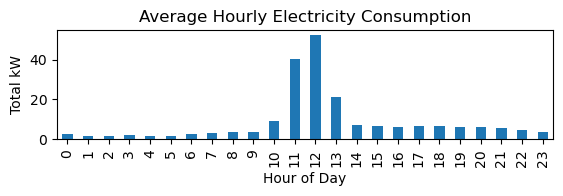

In [11]:
# Hourly consumption plot
plt.subplot(3, 1, 1)
hourly_data = df_merged.groupby('hour')['total_kW'].mean()
hourly_data.plot(kind='bar')
plt.title('Average Hourly Electricity Consumption')
plt.xlabel('Hour of Day')
plt.ylabel('Total kW')

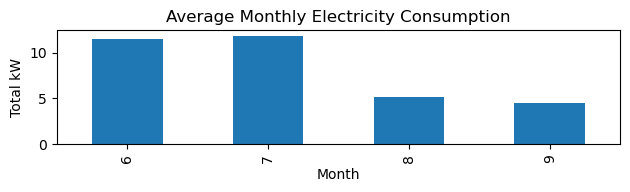

In [13]:
# Monthly consumption plot
plt.subplot(3, 1, 3)
monthly_data = df_merged.groupby('month')['total_kW'].mean()
monthly_data.plot(kind='bar')
plt.title('Average Monthly Electricity Consumption')
plt.xlabel('Month')
plt.ylabel('Total kW')

plt.tight_layout()
plt.show()

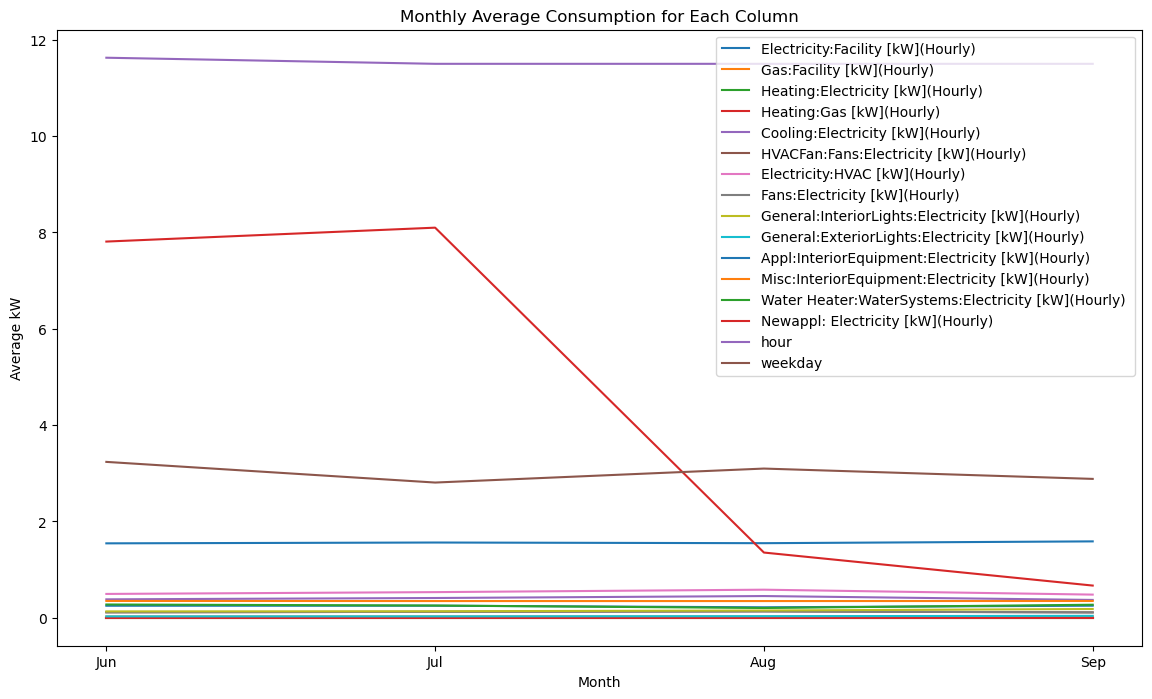

In [14]:
# Calculate the monthly average for each column
monthly_avg = df_merged.groupby('month').mean().drop(columns=['total_kW'])
# Plot the monthly average consumption for each column
plt.figure(figsize=(14, 8))

for column in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[column], label=column)

plt.title('Monthly Average Consumption for Each Column')
plt.xlabel('Month')
plt.ylabel('Average kW')
plt.xticks(ticks=[6, 7, 8, 9], labels=['Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()
plt.show()